In [1]:
!ls /kaggle/input -R

/kaggle/input:
sickle-cell-disease-dataset

/kaggle/input/sickle-cell-disease-dataset:
Negative  Positive

/kaggle/input/sickle-cell-disease-dataset/Negative:
Clear

/kaggle/input/sickle-cell-disease-dataset/Negative/Clear:
100.jpg  116.jpg  131.jpg  147.jpg  29.jpg  44.jpg  5.jpg   75.jpg  90.jpg
101.jpg  117.jpg  132.jpg  14.jpg   2.jpg   45.jpg  60.jpg  76.jpg  91.jpg
102.jpg  118.jpg  133.jpg  15.jpg   30.jpg  46.jpg  61.jpg  77.jpg  92.jpg
103.jpg  119.jpg  134.jpg  16.jpg   31.jpg  47.jpg  62.jpg  78.jpg  93.jpg
104.jpg  11.jpg   135.jpg  17.jpg   32.jpg  48.jpg  63.jpg  79.jpg  94.jpg
105.jpg  120.jpg  136.jpg  18.jpg   33.jpg  49.jpg  64.jpg  7.jpg   95.jpg
106.jpg  121.jpg  137.jpg  19.jpg   34.jpg  4.jpg   65.jpg  80.jpg  96.jpg
107.jpg  122.jpg  138.jpg  1.jpg    35.jpg  50.jpg  66.jpg  81.jpg  97.jpg
108.jpg  123.jpg  139.jpg  20.jpg   36.jpg  51.jpg  67.jpg  82.jpg  98.jpg
109.jpg  124.jpg  13.jpg   21.jpg   37.jpg  52.jpg  68.jpg  83.jpg  99.jpg
10.jpg	 125.jpg  140.jpg  

# Try 1

In [2]:
# In a Kaggle notebook cell, run this:
!git clone https://github.com/NVlabs/stylegan3.git
%cd stylegan3
!pip install -r requirements.txt

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 212 (delta 101), reused 96 (delta 96), pack-reused 46 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 34.92 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/kaggle/working/stylegan3
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
# Create the directory structure for conditional training
!mkdir -p /kaggle/working/dataset/positive
!mkdir -p /kaggle/working/dataset/negative

# Copy the *clean* images into the new structure
!cp /kaggle/input/sickle-cell-disease-dataset/Positive/Unlabelled/*.jpg /kaggle/working/dataset/positive/
!cp /kaggle/input/sickle-cell-disease-dataset/Negative/Clear/*.jpg /kaggle/working/dataset/negative/

# Let's verify the counts
!echo "Positive images: $(ls /kaggle/working/dataset/positive | wc -l)"
!echo "Negative images: $(ls /kaggle/working/dataset/negative | wc -l)"

Positive images: 422
Negative images: 147


In [4]:
# Download the pre-trained AFHQv2 model
!wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl -O /kaggle/working/pretrained.pkl

--2025-10-24 16:02:37--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.185.138.243, 44.233.110.55
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.185.138.243|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl?ssec-algo=AES256&versionId=TsHJSzIRVUwRkXNjCC6J7cCR7nmREwJv&ssec-key=2N8SlP4ZF4MeYYHKBovlrOV%2BZ%2B8LRvunrUsEW%2FW3P1k54XU2Viy9tiFh2%2FosijCIE5%2B0dsIcdXz4Kt3vCoDeOUQxOJo9Hh1d9cBjaeX9aivpPSso%2F2wP8XBLUqcR7vD%2BOCKApUhM%2BgjYTmteBMeux7nYojvJtIDjD4cLgyh%2FrKDoZywHcxMWisjbRGB4dPG%2B9rYFd45EUBpIMMwM4GkW%2FEaTCytVOvgi0RS4O6fSyZS%2Fs9IDqqVxfKNU%2Fg27ZlvrYFtRiCG5S3EBYp93CndI3dCfxHTyXklK57iDMIMgUGcaq5ircU%2BUgrACzqD0V7vmcCRDuzjFmEz3fnHzEZtglw16LHKzgwQchiCPeWOFt6kYZc8foGIGorJuss646LsmR7DD8NYUHj5Z4VxprSZp2KMSwqcfq57x

In [5]:
import os
import json
import glob

# Define the directory and class mapping
data_dir = "/kaggle/working/dataset/"
class_map = {"negative": 0, "positive": 1} # 0 = negative, 1 = positive
labels_list = []

# Scan the directories and build the labels list
print(f"Scanning directory: {data_dir}")
for class_name, class_idx in class_map.items():
    class_path = os.path.join(data_dir, class_name)
    # Find all jpg files
    image_files = glob.glob(os.path.join(class_path, "*.jpg"))
    
    for img_path in image_files:
        # Get the relative path for the JSON file
        # e.g., "positive/100.jpg"
        relative_path = os.path.join(class_name, os.path.basename(img_path))
        
        # Add to our list
        labels_list.append([relative_path, class_idx])

print(f"Found {len(labels_list)} total images.")

# Create the final dictionary in the format StyleGAN expects
output_json = {"labels": labels_list}

# Write the dataset.json file
output_file_path = os.path.join(data_dir, "dataset.json")
with open(output_file_path, "w") as f:
    json.dump(output_json, f, indent=4)

print(f"Successfully created {output_file_path}")

Scanning directory: /kaggle/working/dataset/
Found 569 total images.
Successfully created /kaggle/working/dataset/dataset.json


In [6]:
# Convert your prepared data into the .zip format StyleGAN requires
# --cond=True tells it to look at the subfolders (positive, negative) as labels
# --resolution=512x512 matches our pre-trained model
# Convert your prepared data into the .zip format
# It will now automatically find and include the dataset.json we just created.
!python dataset_tool.py --source=/kaggle/working/dataset \
                       --dest=/kaggle/working/scd-dataset-512x512.zip \
                       --resolution=512x512

  0%|                                                   | 0/569 [00:00<?, ?it/s]/kaggle/working/stylegan3/dataset_tool.py:441: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, { 1: 'L', 3: 'RGB' }[channels])
100%|█████████████████████████████████████████| 569/569 [00:48<00:00, 11.83it/s]


In [19]:
import os
import shutil

original_file = '/kaggle/working/stylegan3/train.py'
patched_file = '/kaggle/working/stylegan3/train_patched.py'

# This is the exact string from your grep output
bad_line_fragment = "betas=[0,0.99]"
good_line_fragment = "betas=[0.0,0.99]" # The fix

found_count = 0
print(f"Starting patch process for: {original_file}")

try:
    with open(original_file, 'r') as f_in, open(patched_file, 'w') as f_out:
        for line in f_in:
            if bad_line_fragment in line:
                # Found the bad line, replace it
                new_line = line.replace(bad_line_fragment, good_line_fragment)
                f_out.write(new_line)
                found_count += 1
                print(f"--- Found and patched line: {new_line.strip()}")
            else:
                # Keep the original line
                f_out.write(line)

    if found_count > 0:
        print(f"Patch complete ({found_count} lines replaced). Replacing original file...")
        # Replace the original file with the patched version
        shutil.move(patched_file, original_file)
        print("File successfully replaced.")
    else:
        print(f"Bad line '{bad_line_fragment}' not found. File might be already patched.")
        os.remove(patched_file)

except FileNotFoundError:
    print(f"ERROR: Cannot find file at {original_file}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Starting patch process for: /kaggle/working/stylegan3/train.py
--- Found and patched line: c.G_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=[0.0,0.99], eps=1e-8)
--- Found and patched line: c.D_opt_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', betas=[0.0,0.99], eps=1e-8)
Patch complete (2 lines replaced). Replacing original file...
File successfully replaced.


In [20]:
!python train.py --outdir=/kaggle/working/training-runs \
                 --data=/kaggle/working/scd-dataset-512x512.zip \
                 --cfg=stylegan3-r \
                 --gpus=1 \
                 --batch=8 \
                 --gamma=6.6 \
                 --mirror=1 \
                 --cond=True \
                 --resume=/kaggle/working/pretrained.pkl \
                 --kimg=200 \
                 --snap=10


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 65536,
    "channel_max": 1024,
    "magnitude_ema_beta": 0.9997227795604651,
    "conv_kernel": 1,
    "use_radial_filters": true
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 6.6,
    "blur_ini

In [16]:
!ls /kaggle/working/stylegan3/training

augment.py  __init__.py  networks_stylegan2.py	__pycache__
dataset.py  loss.py	 networks_stylegan3.py	training_loop.py


# Try 2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2 # OpenCV for reading images

# --- 1. Define Paths and Load Filepaths ---

# Define the base directory
base_dir = Path('/kaggle/input/sickle-cell-disease-dataset')

# Define paths to the specific classes we'll use
positive_dir = base_dir / 'Positive' / 'Unlabelled'
negative_dir = base_dir / 'Negative' / 'Clear'

# Glob the filepaths
positive_paths = list(positive_dir.glob('*.jpg'))
negative_paths = list(negative_dir.glob('*.jpg'))

print(f"Found {len(positive_paths)} positive images.")
print(f"Found {len(negative_paths)} negative images.")

# Create DataFrames
pos_df = pd.DataFrame({'filepath': positive_paths, 'label': 1}) # 1 for Positive
neg_df = pd.DataFrame({'filepath': negative_paths, 'label': 0}) # 0 for Negative

# Combine and shuffle the DataFrame
all_df = pd.concat([pos_df, neg_df], ignore_index=True)
all_df = all_df.sample(frac=1, random_state=42).reset_index(drop=True)

# --------------------
# *** THE FIX ***
# Convert the 'filepath' column from Path objects to strings
all_df['filepath'] = all_df['filepath'].astype(str)
# --------------------

# Map labels to string names (useful for the generator)
all_df['label_str'] = all_df['label'].map({0: 'Negative', 1: 'Positive'})

print(f"\nTotal images: {len(all_df)}")
print(all_df.head())

# Add a check to confirm the type
print(f"\nType of first entry in 'filepath' column: {type(all_df['filepath'].iloc[0])}")

2025-10-25 01:46:49.768515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761356809.945636      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761356810.008567      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 422 positive images.
Found 147 negative images.

Total images: 569
                                            filepath  label label_str
0  /kaggle/input/sickle-cell-disease-dataset/Posi...      1  Positive
1  /kaggle/input/sickle-cell-disease-dataset/Posi...      1  Positive
2  /kaggle/input/sickle-cell-disease-dataset/Posi...      1  Positive
3  /kaggle/input/sickle-cell-disease-dataset/Nega...      0  Negative
4  /kaggle/input/sickle-cell-disease-dataset/Nega...      0  Negative

Type of first entry in 'filepath' column: <class 'str'>


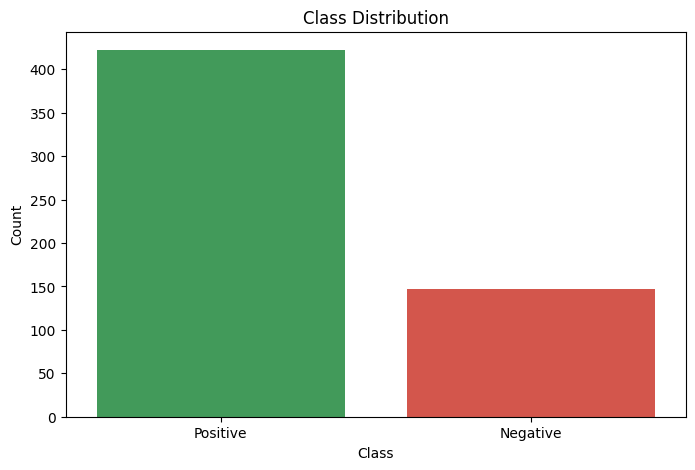

In [2]:
# Plot the distribution of classes
plt.figure(figsize=(8, 5))
sns.countplot(x='label_str', data=all_df, palette=['#34a853', '#ea4335'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [3]:
# --- 3. Split Data and Create Generators ---

# Split into training and validation sets (80% train, 20% validation)
# We use stratify to ensure both classes are represented proportionally
train_df, valid_df = train_test_split(
    all_df,
    test_size=0.2,
    random_state=42,
    stratify=all_df['label_str']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")

# Define image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create Training Data Generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift width
    height_shift_range=0.1, # Randomly shift height
    horizontal_flip=True,   # Randomly flip horizontally
    fill_mode='nearest'
)

# Create Validation Data Generator (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator "flows" from the DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary', # We have 2 classes
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

Training samples: 455
Validation samples: 114
Found 455 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
# --- 1. Define a "Residual Block" ---
# This is the building block of complex networks like ResNet.
# It allows the model to "skip" layers if they aren't useful.

def residual_block(x, filters):
    # Shortcut path (the "skip connection")
    # We use a 1x1 Conv to make sure the dimensions match
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)

    # Main path
    fx = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, (3, 3), padding='same')(fx)
    fx = layers.BatchNormalization()(fx)

    # Add the main path and the shortcut path
    add = layers.Add()([shortcut, fx])
    # Final activation
    output = layers.ReLU()(add)
    return output

# --- 2. Build the "Huge" Model ---
IMG_SIZE = (128, 128)
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Initial "Stem" block (downsamples the image)
x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# --- Block 1 (64 filters) ---
x = residual_block(x, 64)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)

# --- Block 2 (128 filters) ---
x = residual_block(x, 128)
x = residual_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)

# --- Block 3 (256 filters) ---
x = residual_block(x, 256)
x = residual_block(x, 256)

# --- Classifier Head ---
x = layers.GlobalAveragePooling2D()(x) # Better than Flatten()
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# --- 3. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-10-25 03:45:01.119925: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      4,160 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]  

 Total params: 3,117,697 (11.89 MB)

 Trainable params: 3,112,257 (11.87 MB)

 Non-trainable params: 5,440 (21.25 KB)

In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=90, # Set a max number of epochs
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/90


I0000 00:00:1761357064.786103     101 service.cc:148] XLA service 0x7b1868003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761357064.787041     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761357066.612480     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/15 ━━━━━━━━━━━━━━━━━━━━ 6:39 29s/step - accuracy: 0.1875 - loss: 0.9791

I0000 00:00:1761357075.180659     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6307 - loss: 0.6795 - val_accuracy: 0.7456 - val_loss: 0.5699
Epoch 2/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - accuracy: 0.7312 - loss: 0.5684 - val_accuracy: 0.7456 - val_loss: 1.6081
Epoch 3/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 851ms/step - accuracy: 0.7049 - loss: 0.5965 - val_accuracy: 0.7456 - val_loss: 0.5816
Epoch 4/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - accuracy: 0.7144 - loss: 0.5633 - val_accuracy: 0.7456 - val_loss: 0.5776
Epoch 5/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 792ms/step - accuracy: 0.7526 - loss: 0.4857 - val_accuracy: 0.7456 - val_loss: 0.5968
Epoch 6/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 715ms/step - accuracy: 0.7705 - loss: 0.4972 - val_accuracy: 0.7456 - val_loss: 0.8637
Epoch 7/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 753ms/step - accuracy: 0.7646 - loss: 0.5616 - val_accuracy: 0.7456 - val_loss: 0.6799
Epoch 8/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 736ms/step - accuracy: 0.7674 - loss: 0.4964 - val_accuracy: 0.7456 -

## Visualisation

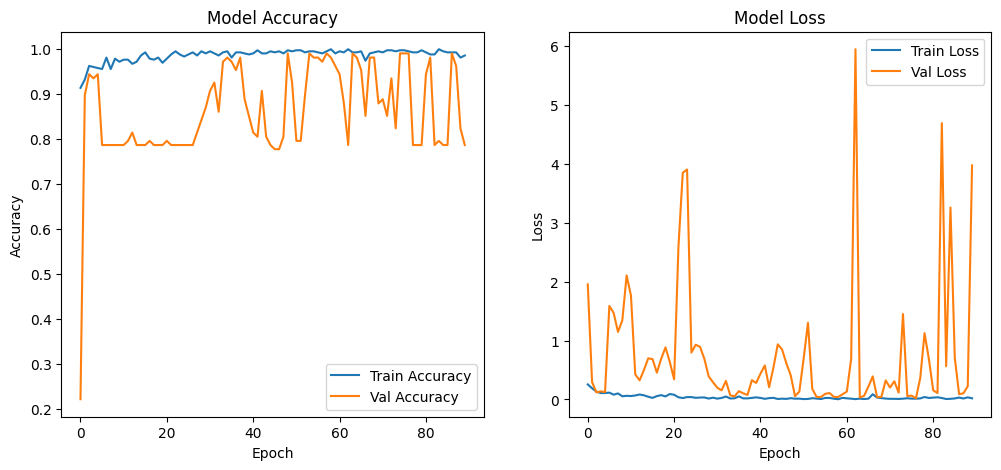

In [53]:
# --- 6. Evaluate the Model ---

# Plot training history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
    Positive       0.79      1.00      0.88        85

    accuracy                           0.79       108
   macro avg       0.39      0.50      0.44       108
weighted avg       0.62      0.79      0.69       108


--- Confusion Matrix ---


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


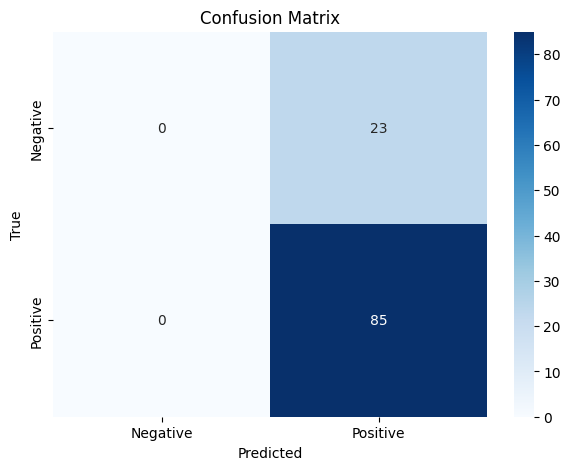

In [54]:
# Get true labels and predictions
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
!pip install lime shap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


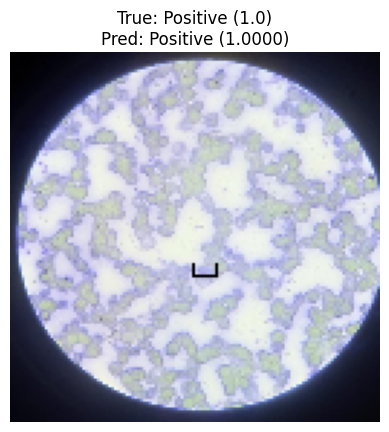

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # We'll need this for Grad-CAM
from tensorflow.keras.models import Model
import tensorflow as tf

# Get a single batch from the validation generator
# Make sure your validation_generator is set to shuffle=False
# (We set this in the original notebook, so it should be fine)
x_batch, y_batch = next(validation_generator)

# Get the first image and its true label
sample_image = x_batch[1]
sample_label = y_batch[1]

# Get the model's prediction
# We add a batch dimension (np.expand_dims)
pred_prob = model.predict(np.expand_dims(sample_image, axis=0))[0][0]
pred_class = (pred_prob > 0.5).astype(int)

# Get the class names from the generator
class_names = {v: k for k, v in validation_generator.class_indices.items()}

# --- Plot the sample image and its prediction ---
plt.imshow(sample_image)
plt.title(f"True: {class_names[sample_label]} ({(sample_label)})\n"
          f"Pred: {class_names[pred_class]} ({pred_prob:.4f})")
plt.axis('off')
plt.show()

--- Running LIME Explanation ---


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

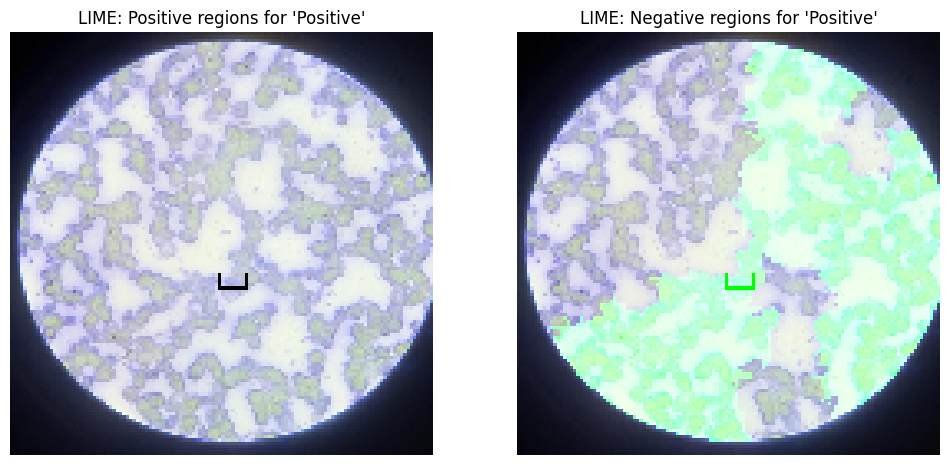

In [56]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("--- Running LIME Explanation ---")

# 1. Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# 2. Define the prediction function LIME needs
# LIME needs a function that takes a batch of images (as numpy arrays)
# and returns prediction probabilities for all classes (N_images, N_classes)
def lime_predict_fn(images):
    preds = model.predict(images)
    # Our model outputs (N, 1) with sigmoid. LIME needs (N, 2).
    # We create a new array: [prob_class_0, prob_class_1]
    return np.hstack([1 - preds, preds])

# 3. Generate the explanation
# This will take 30-60 seconds
explanation = explainer.explain_instance(
    sample_image,
    lime_predict_fn,
    top_labels=2,          # Get explanations for both classes
    hide_color=0,
    num_samples=1000       # Number of images to generate
)

# --- Plot the LIME results ---

# Get the explanation for the predicted class
lime_image_data, lime_mask = explanation.get_image_and_mask(
    pred_class,
    positive_only=True,   # Show only "positive" (pro-prediction) regions
    num_features=5,       # Show top 5 features
    hide_rest=False         # Show the rest of the image
)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lime_image_data)
plt.title(f"LIME: Positive regions for '{class_names[pred_class]}'")
plt.axis('off')

# You can also get a mask for the "negative" (anti-prediction) regions
lime_image_data_neg, lime_mask_neg = explanation.get_image_and_mask(
    pred_class,
    positive_only=False,  # Show "negative" (anti-prediction) regions
    num_features=5,
    hide_rest=False
)

plt.subplot(1, 2, 2)
plt.imshow(lime_image_data_neg)
plt.title(f"LIME: Negative regions for '{class_names[pred_class]}'")
plt.axis('off')

plt.show()

--- Running SHAP Explanation (with full patch) ---


The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 128, 128, 3))']
The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 128, 128, 3))']


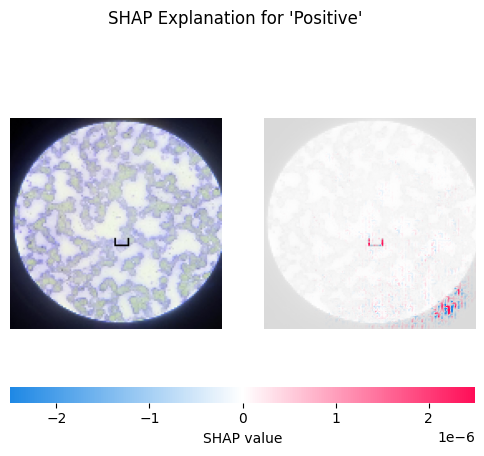

In [57]:
import shap
import tensorflow as tf

# --- THE FIX (NOW FOR BOTH FUNCTIONS) ---

# Patch 1: For `learning_phase()`
# SHAP calls this to check the current mode.
if not hasattr(tf.keras.backend, 'learning_phase'):
    def learning_phase():
        return 0  # 0 = Test / Inference mode
    tf.keras.backend.learning_phase = learning_phase

# Patch 2: For `set_learning_phase()`
# SHAP calls this to set the mode to inference.
if not hasattr(tf.keras.backend, 'set_learning_phase'):
    def set_learning_phase(value):
        pass  # Do nothing, as this is now handled automatically
    tf.keras.backend.set_learning_phase = set_learning_phase
    
# --- END FIX ---


print("--- Running SHAP Explanation (with full patch) ---")

# 1. Get a background dataset
background_batch, _ = next(train_generator)
background_data = background_batch[:20]

# 2. Create the GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# 3. Get SHAP values for our sample image
sample_batch = np.expand_dims(sample_image, axis=0)
shap_values = explainer.shap_values(sample_batch)

# --- Plot the SHAP results ---
# (Plotting code remains the same as before)

# For a binary model with GradientExplainer, shap_values is a list [shap_values_for_output_0].
# The shape is (1, 128, 128, 3).
# We pass the explainer's expected_value and the values.
# The [0] index selects the explanation for the single output neuron.
# The second [0] index selects the first (and only) image in the batch.
shap.image_plot(
    shap_values[0][0],
    pixel_values=sample_batch[0],
    show=False
)
plt.suptitle(f"SHAP Explanation for '{class_names[pred_class]}'")
plt.show()

Running: Grad-CAM
Using Grad-CAM layer: conv2d_18
Running: GradInput


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
invalid value encountered in cast


Running: SmoothGrad
Running: IntegratedGradients
Running: GuidedBackProp
--- Plotting all gradient-based results ---


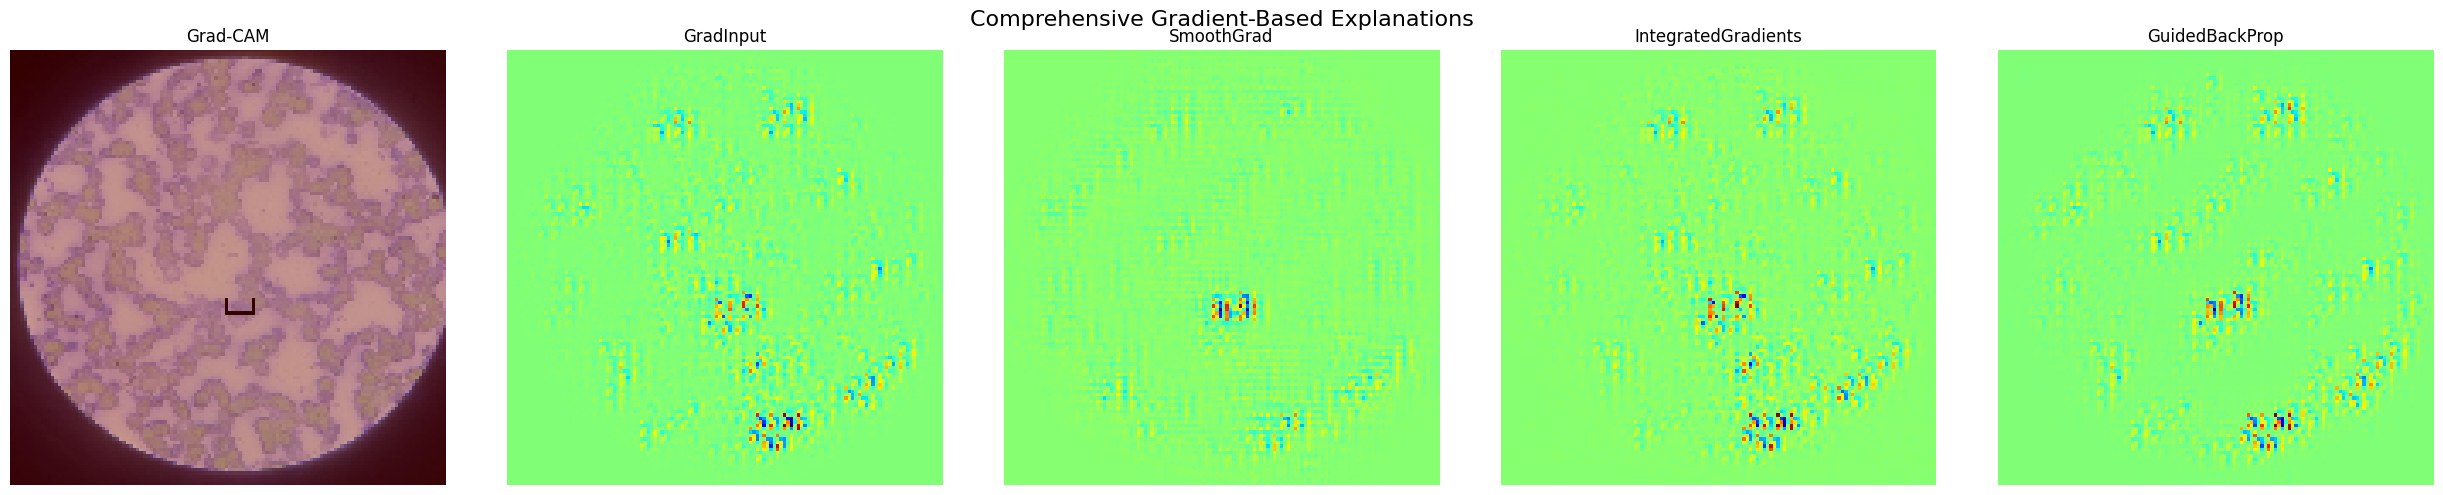

In [58]:
import matplotlib.cm as cm
from tensorflow.keras.models import Model # Ensure Model is imported

# --- 1. Grad-CAM ---
print("Running: Grad-CAM")

# Find the last convolutional layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv2d' in layer.name: # Simpler check for a conv layer
        last_conv_layer = layer
        break
print(f"Using Grad-CAM layer: {last_conv_layer.name}")

# Create the Grad-CAM model (This is the correct functional API way)
grad_model = Model(
    [model.input], 
    [last_conv_layer.output, model.output]
)

# Get gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(sample_batch)
    loss = predictions[:, 0]
grads = tape.gradient(loss, conv_outputs)

# Pool and weigh
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Superimpose
heatmap_resized = (cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0])) * 255).astype(np.uint8)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
original_img_uint8 = (sample_image * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(original_img_uint8, 0.6, heatmap_colored, 0.4, 0)

# --- 2. Helper functions for other gradient methods ---
@tf.function
def compute_input_gradients(input_batch, model_to_use):
    with tf.GradientTape() as tape:
        tape.watch(input_batch)
        outputs = model_to_use(input_batch)
    return tape.gradient(outputs, input_batch)

def visualize_saliency_map(saliency_map_batch, title, ax):
    if saliency_map_batch is None or np.isnan(saliency_map_batch).all():
        ax.set_title(f"{title}\n(Failed - NaN gradient)")
        ax.axis('off')
        return
        
    saliency_map = saliency_map_batch[0]
    saliency_map_gray = np.sum(saliency_map, axis=-1)
    
    if not np.isfinite(saliency_map_gray).all():
        ax.set_title(f"{title}\n(Failed - NaN/Inf value)")
        ax.axis('off')
        return

    ax.imshow(saliency_map_gray, cmap='jet')
    ax.set_title(title)
    ax.axis('off')
logits_model = Model(model.input, model.layers[-2].output)
# --- 3. GradInput (Gradient * Input) ---
print("Running: GradInput")
grad_val = compute_input_gradients(sample_batch, logits_model)
grad_input = sample_batch * grad_val.numpy() if grad_val is not None else None

# --- 4. SmoothGrad ---
print("Running: SmoothGrad")
n_samples = 50
noise_std = 0.15
all_grads = []
for _ in range(n_samples):
    noise = np.random.normal(0, noise_std, sample_batch.shape)
    noisy_image = np.clip(sample_batch + noise, 0, 1)
    grads = compute_input_gradients(tf.constant(noisy_image, dtype=tf.float32), logits_model)
    if grads is not None:
        all_grads.append(grads)
smooth_grad = np.mean(all_grads, axis=0) if all_grads else None

# --- 5. IntegratedGradients (IG) ---
print("Running: IntegratedGradients")
baseline = np.zeros_like(sample_batch)
m_steps = 100
alphas = np.linspace(0, 1, m_steps)
interpolated_images = np.vstack([baseline + alpha * (sample_batch - baseline) for alpha in alphas])
grads = compute_input_gradients(tf.constant(interpolated_images, dtype=tf.float32), logits_model)

if grads is not None:
    grads = grads.numpy()
    grads_avg = (grads[:-1] + grads[1:]) / 2.0
    integral = np.mean(grads_avg, axis=0)
    integrated_gradients = (sample_batch[0] - baseline[0]) * integral
    integrated_gradients = np.expand_dims(integrated_gradients, axis=0)
else:
    integrated_gradients = None

# --- 6. GuidedBackProp ---
print("Running: GuidedBackProp")
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, dy.dtype) * tf.cast(x > 0, x.dtype) * dy
    return tf.nn.relu(x), grad

# Clone the model (This works for functional models)
guided_model = Model.from_config(model.get_config())
guided_model.set_weights(model.get_weights())

# Replace all 'relu' activations
for layer in guided_model.layers:
    if hasattr(layer, 'activation') and layer.activation == keras.activations.get('relu'):
        layer.activation = guided_relu
        
# Create the logits model (Correct for functional model)
guided_logits_model = Model(guided_model.input, guided_model.layers[-2].output)
guided_grads = compute_input_gradients(sample_batch, guided_logits_model)
guided_grads = guided_grads.numpy() if guided_grads is not None else None


# --- 7. Plot All Results ---
print("--- Plotting all gradient-based results ---")
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes[0].imshow(superimposed_img); axes[0].set_title("Grad-CAM"); axes[0].axis('off')
visualize_saliency_map(grad_input, "GradInput", axes[1])
visualize_saliency_map(smooth_grad, "SmoothGrad", axes[2])
visualize_saliency_map(integrated_gradients, "IntegratedGradients", axes[3])
visualize_saliency_map(guided_grads, "GuidedBackProp", axes[4])
plt.suptitle("Comprehensive Gradient-Based Explanations", fontsize=16)
plt.tight_layout()
plt.show()

--- Running Occlusion Sensitivity ---


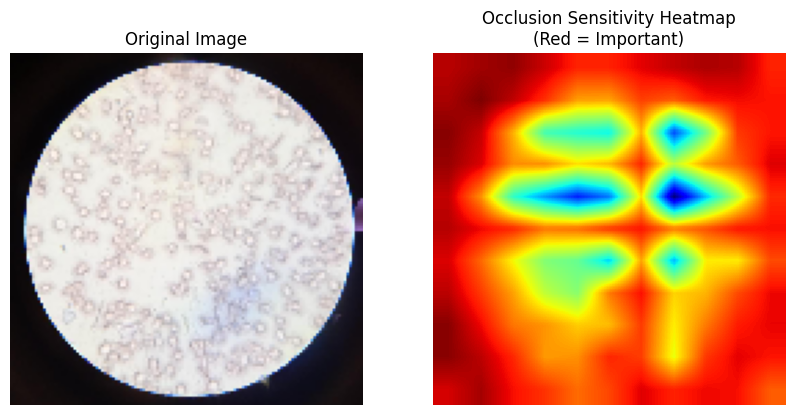

In [15]:
import numpy as np
import matplotlib.pyplot as plt

print("--- Running Occlusion Sensitivity ---")

# --- 1. Define Parameters ---
# (Using the same 'sample_image' and 'pred_prob' from before)

occlusion_size = 20  # Size of the grey square (e.g., 20x20 pixels)
stride = 10          # How many pixels to slide the square each time
occlusion_color = 0.5 # Grey (0.5 on a 0-1 scale)

# Get the original "Positive" class probability
original_prob = pred_prob

# Create a heatmap to store the results
heatmap_shape = (
    (sample_image.shape[0] - occlusion_size) // stride + 1,
    (sample_image.shape[1] - occlusion_size) // stride + 1
)
heatmap = np.zeros(heatmap_shape)

# --- 2. Iterate and Occlude ---
images_to_predict = []
y_coords = []
x_coords = []

# Create a batch of all occluded images
for y in range(0, sample_image.shape[0] - occlusion_size + 1, stride):
    for x in range(0, sample_image.shape[1] - occlusion_size + 1, stride):
        # Create a copy
        occluded_image = np.copy(sample_image)
        
        # Apply the occlusion
        occluded_image[y : y + occlusion_size, x : x + occlusion_size, :] = occlusion_color
        
        images_to_predict.append(occluded_image)
        y_coords.append(y // stride)
        x_coords.append(x // stride)

# --- 3. Run Prediction in a Single Batch ---
# This is much faster than predicting one by one
predictions = model.predict(np.array(images_to_predict), verbose=0)

# --- 4. Populate the Heatmap ---
for i, pred in enumerate(predictions):
    prob = pred[0]
    # Record the *drop* in probability
    heatmap[y_coords[i], x_coords[i]] = original_prob - prob

# --- 5. Plot the Result ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# Resize the small heatmap to the full image size for visualization
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Occlusion Sensitivity Heatmap\n(Red = Important)")
plt.axis('off')

plt.show()

In [20]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.7 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.17.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [34]:
layers_to_visualize

['conv2d', 'conv2d_5', 'conv2d_9', 'conv2d_13', 'conv2d_18']

--- Visualizing Filter 2 of Layer 'conv2d_17' ---
--- Running Gradient Ascent ---
--- Visualization Complete ---


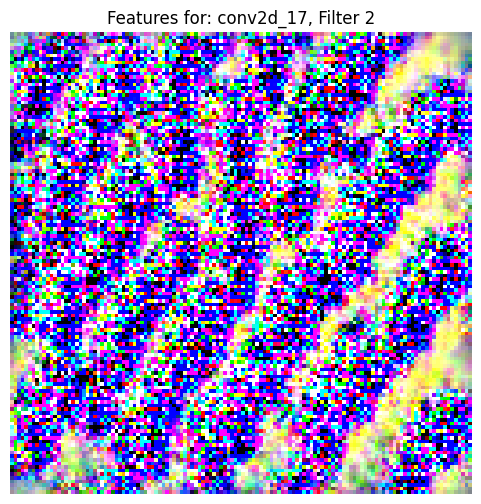

Visualizing filter 0...


ValueError: `inputs` argument cannot be empty. Received:
inputs=[]
outputs=<KerasTensor shape=(None, 8, 8), dtype=float32, sparse=False, name=keras_tensor_190>

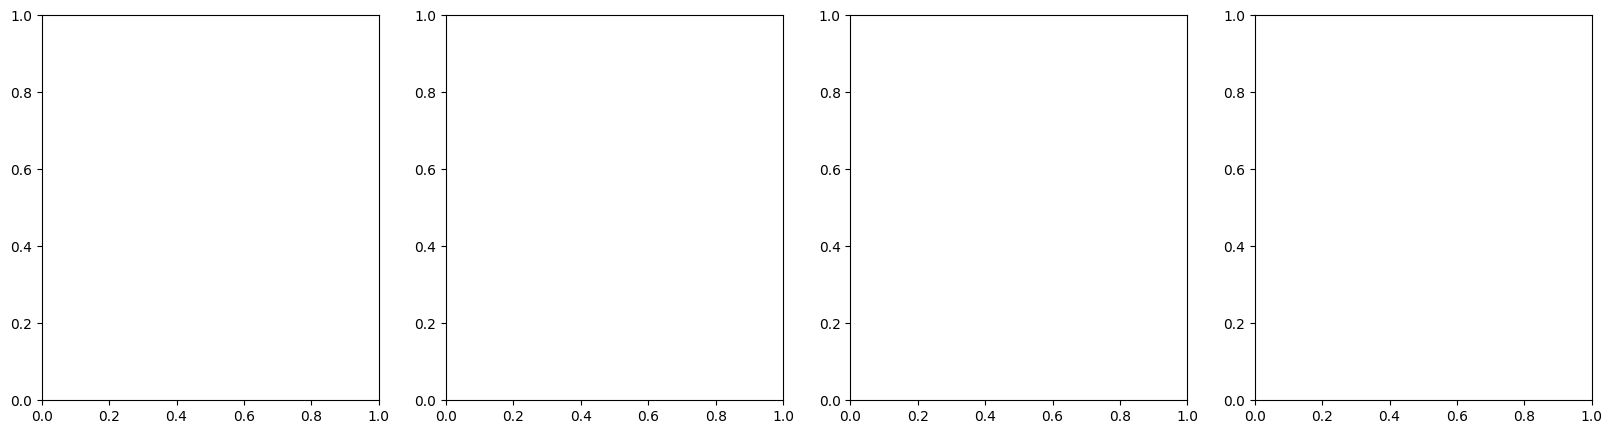

In [23]:
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Layer and Filter ---
layer_name = 'conv2d_17'    # The last conv layer in your VGG model
filter_index = 2        # Let's visualize the 2nd filter in this layer

# --- 2. Create the Feature Extractor Model ---
# (This assumes 'model' is your trained VGG-style Sequential model)
layer_output = model.get_layer(layer_name).output

# We create a new model that outputs *only* the specific filter 
# from the chosen layer.
feature_extractor = Model(
    inputs=[model.input], 
    outputs=layer_output[:, :, :, filter_index]
)

print(f"--- Visualizing Filter {filter_index} of Layer '{layer_name}' ---")
# --- 3. Helper function for processing the image ---
# These small blurs and shifts prevent the model from creating

kernel_weights = tf.constant([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=tf.float32) / 16.0 # Normalize

# Reshape for tf.nn.depthwise_conv2d
# [height, width, in_channels, multiplier]
kernel_weights = tf.expand_dims(kernel_weights, axis=-1)
# Apply the same blur to all 3 (R,G,B) channels
kernel_weights = tf.tile(kernel_weights, [1, 1, 3]) 
# (3, 3, 3, 1)
kernel_weights = tf.expand_dims(kernel_weights, axis=-1)
# --- END NEW PART ---

@tf.function
def process_image(img, size=128):
    # Add a little "jitter" (randomly shift the image)
    shift_x, shift_y = np.random.randint(-4, 5, 2)
    img = tf.roll(img, shift=[shift_x, shift_y], axis=[1, 2])
    
    # --- THIS IS THE FIX ---
    # Apply our pure TensorFlow blur
    img = tf.nn.depthwise_conv2d(img, kernel_weights, strides=[1, 1, 1, 1], padding='SAME')
    # --- END FIX ---
    
    return img

# --- 4. The Gradient Ascent Step ---
@tf.function
def gradient_ascent_step(img, learning_rate=10.0):
    with tf.GradientTape() as tape:
        tape.watch(img)
        # Get the activation
        activation = feature_extractor(img)
        # We want to maximize the *mean* activation of the filter
        loss = tf.reduce_mean(activation)
    
    # Get the gradients
    grads = tape.gradient(loss, img)
    
    # Normalize the gradients
    grads /= (tf.math.reduce_std(grads) + 1e-8)
    
    # Update the image
    img += learning_rate * grads
    img = tf.clip_by_value(img, -1, 1) # Keep pixels in a valid range
    return img

# --- 5. The Main Loop ---
def visualize_filter(steps=100):
    # Start with a random grey image with some noise
    img = (np.random.uniform(size=(1, IMG_SIZE[0], IMG_SIZE[1], 3)) - 0.5) * 0.2
    img = tf.constant(img, dtype=tf.float32)

    for i in range(steps):
        # Apply jitter/blur
        img = process_image(img)
        # Apply gradient ascent
        img = gradient_ascent_step(img)

    # Convert the final tensor back to a displayable image
    img = img[0].numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize to [0, 1]
    return img

print("--- Running Gradient Ascent ---")
generated_image = visualize_filter()
print("--- Visualization Complete ---")

# --- 6. Plot the Result ---
plt.figure(figsize=(6, 6))
plt.imshow(generated_image)
plt.title(f"Features for: {layer_name}, Filter {filter_index}")
plt.axis('off')
plt.show()
# --- Visualize multiple filters to compare ---
filters_to_visualize = [0, 10, 20, 30]
num_filters = len(filters_to_visualize)

fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))

for i, filter_index in enumerate(filters_to_visualize):
    print(f"Visualizing filter {filter_index}...")
    
    # Create a new feature extractor for this specific filter
    feature_extractor = Model(
        inputs=model.layers[0].input, 
        outputs=layer_output[:, :, :, filter_index]
    )
    
    # Run the gradient ascent
    generated_image = visualize_filter(steps=100)
    
    # Plot it
    axes[i].imshow(generated_image)
    axes[i].set_title(f"Filter {filter_index}")
    axes[i].axis('off')

plt.suptitle(f"Features learned by layer '{layer_name}'", fontsize=16)
plt.show()

--- Feature Visualization functions defined ---
Found 19 Conv2D layers: ['conv2d', 'conv2d_2', 'conv2d_1', 'conv2d_3', 'conv2d_5', 'conv2d_4', 'conv2d_6', 'conv2d_8', 'conv2d_7', 'conv2d_9', 'conv2d_11', 'conv2d_10', 'conv2d_12', 'conv2d_14', 'conv2d_13', 'conv2d_15', 'conv2d_17', 'conv2d_16', 'conv2d_18']
Will visualize these layers: ['conv2d', 'conv2d_2', 'conv2d_1', 'conv2d_3', 'conv2d_5', 'conv2d_4', 'conv2d_6', 'conv2d_8', 'conv2d_7', 'conv2d_9', 'conv2d_11', 'conv2d_10', 'conv2d_12', 'conv2d_14', 'conv2d_13', 'conv2d_15', 'conv2d_17', 'conv2d_16', 'conv2d_18']
Visualizing: Layer 'conv2d', Filter 0
Visualizing: Layer 'conv2d_2', Filter 0
Visualizing: Layer 'conv2d_1', Filter 0
Visualizing: Layer 'conv2d_3', Filter 0
Visualizing: Layer 'conv2d_5', Filter 0
Visualizing: Layer 'conv2d_4', Filter 0
Visualizing: Layer 'conv2d_6', Filter 0
Visualizing: Layer 'conv2d_8', Filter 0
Visualizing: Layer 'conv2d_7', Filter 0
Visualizing: Layer 'conv2d_9', Filter 0
Visualizing: Layer 'conv2d_11

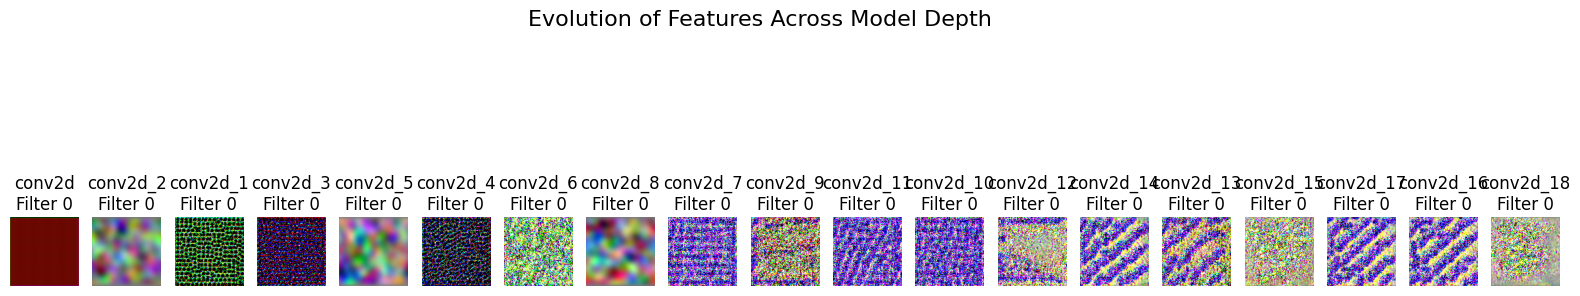

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Custom Gaussian Blur (Pure TensorFlow) ---
# This kernel is used to blur the image slightly,
# which helps create smoother visualizations.
kernel_weights = tf.constant([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=tf.float32) / 16.0 # Normalize

kernel_weights = tf.expand_dims(kernel_weights, axis=-1)
kernel_weights = tf.tile(kernel_weights, [1, 1, 3]) 
kernel_weights = tf.expand_dims(kernel_weights, axis=-1)
# --- End Blur Kernel ---


@tf.function
def process_image(img):
    """Applies jitter and blur to the image."""
    # Add a little "jitter" (randomly shift the image)
    shift_x, shift_y = np.random.randint(-4, 5, 2)
    img = tf.roll(img, shift=[shift_x, shift_y], axis=[1, 2])
    
    # Apply our pure TensorFlow blur
    img = tf.nn.depthwise_conv2d(img, kernel_weights, strides=[1, 1, 1, 1], padding='SAME')
    
    return img

@tf.function
def gradient_ascent_step(img, feature_extractor, learning_rate=10.0):
    """Performs one step of gradient ascent."""
    with tf.GradientTape() as tape:
        tape.watch(img)
        # Get the activation
        activation = feature_extractor(img)
        # We want to maximize the *mean* activation of the filter
        loss = tf.reduce_mean(activation)
    
    # Get the gradients
    grads = tape.gradient(loss, img)
    
    # Normalize the gradients
    grads /= (tf.math.reduce_std(grads) + 1e-8)
    
    # Update the image
    img += learning_rate * grads
    img = tf.clip_by_value(img, -1, 1) # Keep pixels in a valid range
    return img

def visualize_filter(feature_extractor, steps=100):
    """Runs the full gradient ascent loop."""
    # Start with a random grey image with some noise
    img = (np.random.uniform(size=(1, IMG_SIZE[0], IMG_SIZE[1], 3)) - 0.5) * 0.2
    img = tf.constant(img, dtype=tf.float32)

    for i in range(steps):
        img = process_image(img)
        img = gradient_ascent_step(img, feature_extractor)

    # Convert the final tensor back to a displayable image
    img = img[0].numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize to [0, 1]
    return img

print("--- Feature Visualization functions defined ---")
# --- 1. Find all 'Conv2D' layers in the model ---
conv_layer_names = []
for layer in model.layers:
    # Check if the layer is a Conv2D layer
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer_names.append(layer.name)

print(f"Found {len(conv_layer_names)} Conv2D layers: {conv_layer_names}")

# --- 2. Select a few representative layers ---
# We'll pick the first, some from the middle, and one of the last
num_layers = len(conv_layer_names)
# layers_to_visualize = [
#     conv_layer_names[0],                            # The very first layer
#     conv_layer_names[num_layers // 4],                # A layer from the first quarter
#     conv_layer_names[num_layers // 2],                # A layer from the middle
#     conv_layer_names[num_layers * 3 // 4],            # A layer from the third quarter
#     conv_layer_names[-1]                            # The very last Conv2D layer
# ]
layers_to_visualize = conv_layer_names
# Remove duplicates if any
layers_to_visualize = sorted(list(set(layers_to_visualize)), key=conv_layer_names.index)

print(f"Will visualize these layers: {layers_to_visualize}")

# --- 3. Loop, Visualize, and Plot ---
fig, axes = plt.subplots(1, len(layers_to_visualize), figsize=(20, 5))
filter_index = 0 # We'll visualize the first filter (index 0) from each layer

for i, layer_name in enumerate(layers_to_visualize):
    print(f"Visualizing: Layer '{layer_name}', Filter {filter_index}")
    
    # Get the layer's output
    layer_output = model.get_layer(layer_name).output

    # Create the feature extractor model for this specific filter
    feature_extractor = Model(
        inputs=[model.input], 
        outputs=layer_output[:, :, :, filter_index]
    )
    
    # Run the gradient ascent
    generated_image = visualize_filter(feature_extractor, steps=100)
    
    # Plot it
    axes[i].imshow(generated_image)
    axes[i].set_title(f"{layer_name}\nFilter {filter_index}")
    axes[i].axis('off')

plt.suptitle("Evolution of Features Across Model Depth", fontsize=16)
plt.show()


--- Using this validation image for DeepDream ---


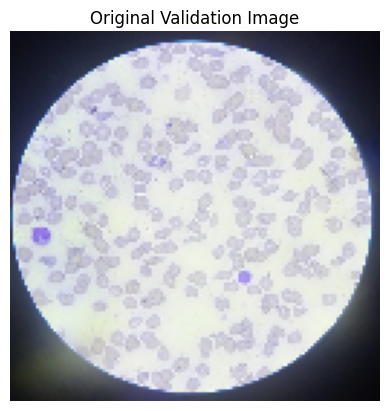

--- Running DeepDream on layers: ['conv2d', 'conv2d_2', 'conv2d_1', 'conv2d_3', 'conv2d_5', 'conv2d_4', 'conv2d_6', 'conv2d_8', 'conv2d_7', 'conv2d_9', 'conv2d_11', 'conv2d_10', 'conv2d_12', 'conv2d_14', 'conv2d_13', 'conv2d_15', 'conv2d_17', 'conv2d_16', 'conv2d_18'] ---
Dreaming with: Layer 'conv2d', Filter 0
Dreaming with: Layer 'conv2d_2', Filter 0
Dreaming with: Layer 'conv2d_1', Filter 0
Dreaming with: Layer 'conv2d_3', Filter 0
Dreaming with: Layer 'conv2d_5', Filter 0
Dreaming with: Layer 'conv2d_4', Filter 0
Dreaming with: Layer 'conv2d_6', Filter 0
Dreaming with: Layer 'conv2d_8', Filter 0
Dreaming with: Layer 'conv2d_7', Filter 0
Dreaming with: Layer 'conv2d_9', Filter 0
Dreaming with: Layer 'conv2d_11', Filter 0
Dreaming with: Layer 'conv2d_10', Filter 0
Dreaming with: Layer 'conv2d_12', Filter 0
Dreaming with: Layer 'conv2d_14', Filter 0
Dreaming with: Layer 'conv2d_13', Filter 0
Dreaming with: Layer 'conv2d_15', Filter 0
Dreaming with: Layer 'conv2d_17', Filter 0
Dreaming

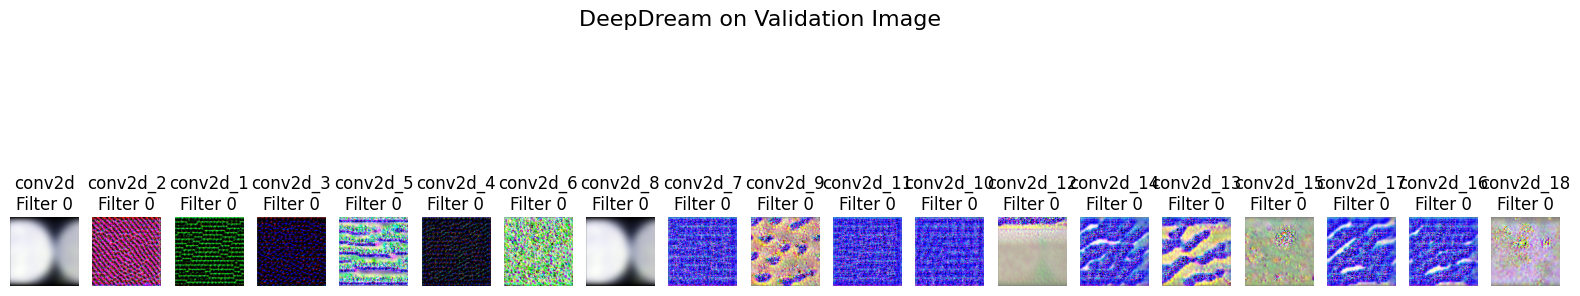

In [38]:
# (This code is just for completeness, you may not need to re-run it)
x_batch, y_batch = next(validation_generator)
sample_image = x_batch[0]

print("--- Using this validation image for DeepDream ---")
plt.imshow(sample_image)
plt.title("Original Validation Image")
plt.axis('off')
plt.show()
def run_deepdream(start_image, feature_extractor, steps=100, learning_rate=1.0):
    """Runs the gradient ascent loop starting from a real image."""
    
    # 1. Convert the sample image to the correct format
    # We add a batch dimension and create a tf.constant
    img = tf.constant(np.expand_dims(start_image, axis=0), dtype=tf.float32)

    # 2. Run the gradient ascent loop
    for i in range(steps):
        img = process_image(img) # Apply jitter/blur
        
        # Note: We pass the learning rate to the step function
        img = gradient_ascent_step(img, feature_extractor, learning_rate=learning_rate)

    # 3. Convert back to a displayable image
    img = img[0].numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize to [0, 1]
    return img

# --- 1. Get the list of layers to visualize ---
# (Using the same list as before)
conv_layer_names = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer_names.append(layer.name)

num_layers = len(conv_layer_names)
# layers_to_visualize = [
#     conv_layer_names[0],
#     conv_layer_names[num_layers // 4],
#     conv_layer_names[num_layers // 2],
#     conv_layer_names[num_layers * 3 // 4],
#     conv_layer_names[-1]
# ]
layers_to_visualize = sorted(list(set(conv_layer_names)), key=conv_layer_names.index)

print(f"--- Running DeepDream on layers: {layers_to_visualize} ---")

# --- 2. Loop, Visualize, and Plot ---
fig, axes = plt.subplots(1, len(layers_to_visualize), figsize=(20, 5))
filter_index = 0 # We'll visualize the first filter (index 0) from each layer

for i, layer_name in enumerate(layers_to_visualize):
    print(f"Dreaming with: Layer '{layer_name}', Filter {filter_index}")
    
    # Get the layer's output
    layer_output = model.get_layer(layer_name).output

    # Create the feature extractor model for this specific filter
    feature_extractor = Model(
        inputs=[model.input], 
        outputs=layer_output[:, :, :, filter_index]
    )
    
    # Run the DeepDream process
    # Note: A smaller learning rate is often better for real images
    dream_image = run_deepdream(sample_image, feature_extractor, steps=100, learning_rate=1.0)
    
    # Plot it
    axes[i].imshow(dream_image)
    axes[i].set_title(f"{layer_name}\nFilter {filter_index}")
    axes[i].axis('off')

plt.suptitle("DeepDream on Validation Image", fontsize=16)
plt.show()

In [14]:
model.save("complexNet.keras")

## Try 2.1


In [72]:
# --- 1. Build the "Universally Compatible" Model ---
# This model is a simple sequential stack (VGG-style)
# It avoids layers like BatchNormalization or Add(),
# which makes it compatible with the 'iNNvestigate' library.

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Classifier Head
    layers.Flatten(name='flatten'),
    layers.Dense(256, activation='relu', name='fc1'),
    layers.Dropout(0.5, name='dropout1'),
    layers.Dense(256, activation='relu', name='fc2'),
    layers.Dense(1, activation='sigmoid', name='output')
])

# --- 2. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,741,921 (33.35 MB)

 Trainable params: 8,741,921 (33.35 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# --- 3. Train the New Model ---
# (You must run this cell again!)

history = model.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator,
    # callbacks=[early_stopping] # Re-use the same EarlyStopping callback
)

# After this, you can also re-run the evaluation cell 
# (classification_report, confusion_matrix)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 940ms/step - accuracy: 0.6226 - loss: 0.6318 - val_accuracy: 0.7456 - val_loss: 0.6706
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 810ms/step - accuracy: 0.7493 - loss: 0.5801 - val_accuracy: 0.7456 - val_loss: 0.5793
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 756ms/step - accuracy: 0.7190 - loss: 0.6216 - val_accuracy: 0.7456 - val_loss: 0.5775
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 739ms/step - accuracy: 0.7429 - loss: 0.5745 - val_accuracy: 0.7456 - val_loss: 0.5820
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 724ms/step - accuracy: 0.7454 - loss: 0.5928 - val_accuracy: 0.7456 - val_loss: 0.5675
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 823ms/step - accuracy: 0.7349 - loss: 0.5853 - val_accuracy: 0.7456 - val_loss: 0.5623
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.7347 - loss: 0.5737 - val_accuracy: 0.7456 - val_loss: 0.6057
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step - accuracy: 0.7237 - loss: 0.5847 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample image shape: (128, 128, 3)
Predicted class: Positive (1.0000)
--- Logits model created ---


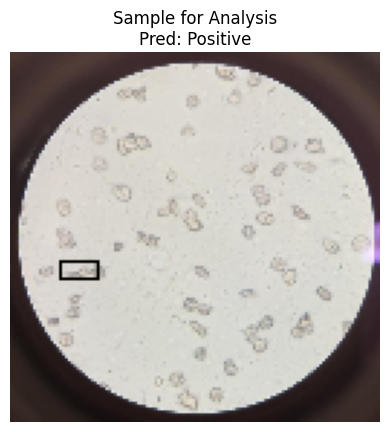

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 # For Grad-CAM

# --- 1. Get a Sample Image ---
# (Assuming validation_generator is defined and has shuffle=False)
x_batch, y_batch = next(validation_generator)
sample_image = x_batch[0]
sample_batch = np.expand_dims(sample_image, axis=0) # Shape (1, 128, 128, 3)

# Get class names
class_names = {v: k for k, v in validation_generator.class_indices.items()}

# Get prediction
pred_prob = model.predict(sample_batch)[0][0]
pred_class = (pred_prob > 0.5).astype(int)

print(f"Sample image shape: {sample_image.shape}")
print(f"Predicted class: {class_names[pred_class]} ({pred_prob:.4f})")

# --- 2. Create a "Logits" Model (FIXED) ---
# We use model.layers[0].input instead of model.input
logits_model = Model(model.layers[0].input, model.layers[-2].output)
print("--- Logits model created ---")

# --- 3. Plot the Sample ---
plt.imshow(sample_image)
plt.title(f"Sample for Analysis\nPred: {class_names[pred_class]}")
plt.axis('off')
plt.show()

Running: Grad-CAM
Using Grad-CAM layer: conv3_2
Running: GradInput


invalid value encountered in cast


Running: SmoothGrad
Running: IntegratedGradients
Running: GuidedBackProp
--- Plotting all gradient-based results ---


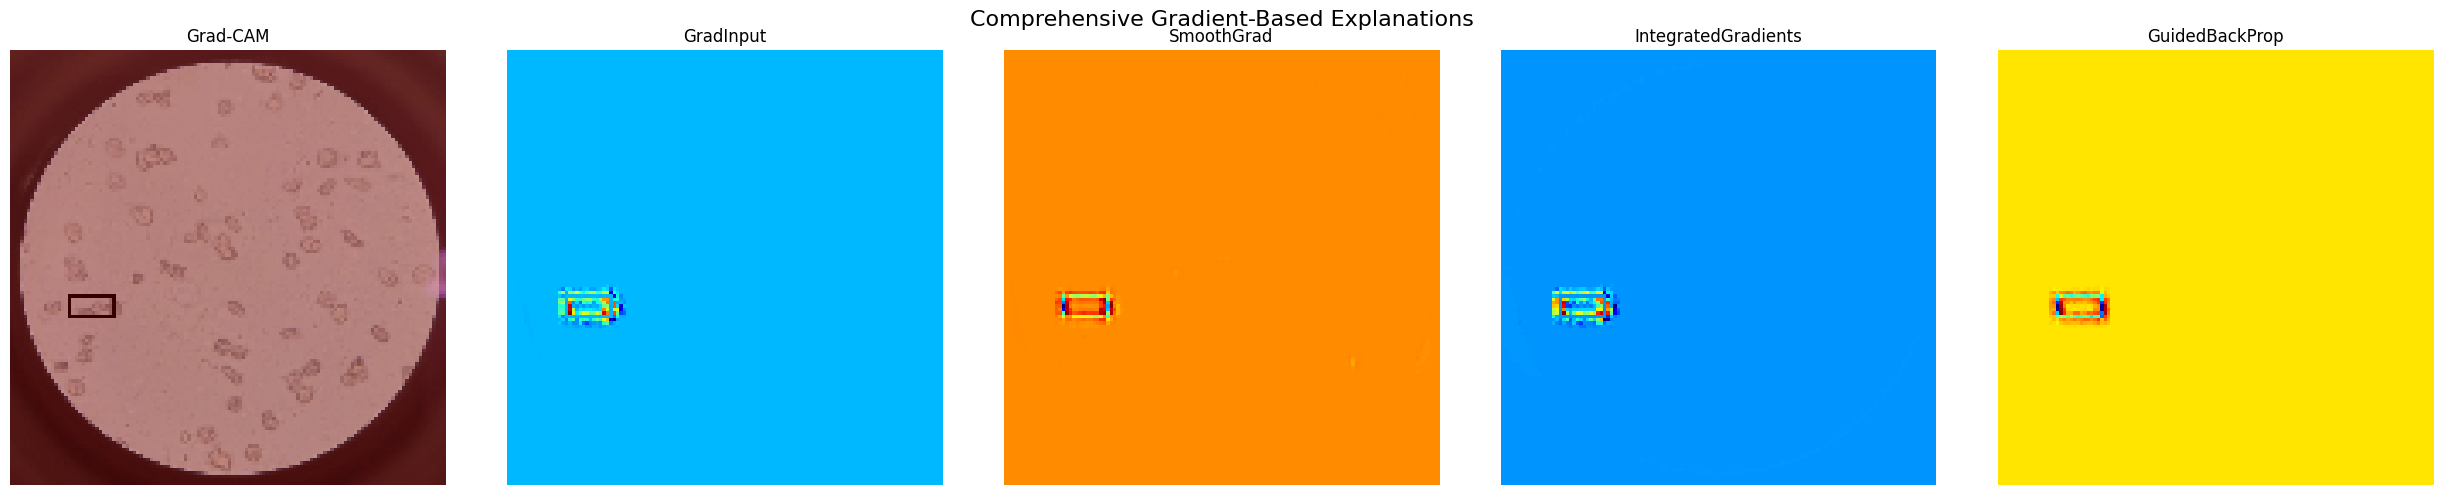

In [69]:
import matplotlib.cm as cm
from tensorflow.keras.models import Model # Ensure Model is imported
# We also need Sequential for the fix
from tensorflow.keras.models import Sequential 

# --- 1. Grad-CAM ---
print("Running: Grad-CAM")

last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer = layer
        break
print(f"Using Grad-CAM layer: {last_conv_layer.name}")

# Create the Grad-CAM model
grad_model = Model(
    [model.layers[0].input], 
    [last_conv_layer.output, model.layers[-1].output]
)

# Get gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(sample_batch)
    loss = predictions[:, 0]
grads = tape.gradient(loss, conv_outputs)

# Pool and weigh
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Superimpose
heatmap_resized = (cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0])) * 255).astype(np.uint8)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
original_img_uint8 = (sample_image * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(original_img_uint8, 0.6, heatmap_colored, 0.4, 0)

# --- 2. Helper functions for other gradient methods ---
@tf.function
def compute_input_gradients(input_batch, model_to_use):
    with tf.GradientTape() as tape:
        tape.watch(input_batch)
        outputs = model_to_use(input_batch)
    return tape.gradient(outputs, input_batch)

def visualize_saliency_map(saliency_map_batch, title, ax):
    if saliency_map_batch is None or np.isnan(saliency_map_batch).all():
        ax.set_title(f"{title}\n(Failed - NaN gradient)")
        ax.axis('off')
        return
        
    saliency_map = saliency_map_batch[0]
    saliency_map_gray = np.sum(saliency_map, axis=-1)
    
    # Check for NaN/Inf values which cause the 'invalid value' warning
    if not np.isfinite(saliency_map_gray).all():
        ax.set_title(f"{title}\n(Failed - NaN/Inf value)")
        ax.axis('off')
        return

    ax.imshow(saliency_map_gray, cmap='jet')
    ax.set_title(title)
    ax.axis('off')

# --- 3. GradInput (Gradient * Input) ---
print("Running: GradInput")
grad_val = compute_input_gradients(sample_batch, logits_model)
if grad_val is not None:
    grad_input = sample_batch * grad_val.numpy()
else:
    grad_input = None

# --- 4. SmoothGrad ---
print("Running: SmoothGrad")
n_samples = 50
noise_std = 0.15
all_grads = []
for _ in range(n_samples):
    noise = np.random.normal(0, noise_std, sample_batch.shape)
    noisy_image = np.clip(sample_batch + noise, 0, 1)
    grads = compute_input_gradients(tf.constant(noisy_image, dtype=tf.float32), logits_model)
    if grads is not None:
        all_grads.append(grads)
        
if all_grads:
    smooth_grad = np.mean(all_grads, axis=0)
else:
    smooth_grad = None

# --- 5. IntegratedGradients (IG) ---
print("Running: IntegratedGradients")
baseline = np.zeros_like(sample_batch)
m_steps = 100
alphas = np.linspace(0, 1, m_steps)
interpolated_images = np.vstack([baseline + alpha * (sample_batch - baseline) for alpha in alphas])
grads = compute_input_gradients(tf.constant(interpolated_images, dtype=tf.float32), logits_model)

if grads is not None:
    grads = grads.numpy()
    grads_avg = (grads[:-1] + grads[1:]) / 2.0
    integral = np.mean(grads_avg, axis=0)
    integrated_gradients = (sample_batch[0] - baseline[0]) * integral
    integrated_gradients = np.expand_dims(integrated_gradients, axis=0)
else:
    integrated_gradients = None

# --- 6. GuidedBackProp ---
print("Running: GuidedBackProp")
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, dy.dtype) * tf.cast(x > 0, x.dtype) * dy
    return tf.nn.relu(x), grad

# --- THE FIX IS HERE ---
# Use keras.Sequential.from_config() instead of Model.from_config()
guided_model = keras.Sequential.from_config(model.get_config())
# --- END FIX ---

guided_model.set_weights(model.get_weights())

# Replace all 'relu' activations
for layer in guided_model.layers:
    if hasattr(layer, 'activation') and layer.activation == keras.activations.get('relu'):
        layer.activation = guided_relu
        
guided_logits_model = Model(guided_model.layers[0].input, guided_model.layers[-2].output)
guided_grads = compute_input_gradients(sample_batch, guided_logits_model)
if guided_grads is not None:
    guided_grads = guided_grads.numpy()
else:
    guided_grads = None


# --- 7. Plot All Results ---
print("--- Plotting all gradient-based results ---")
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes[0].imshow(superimposed_img); axes[0].set_title("Grad-CAM"); axes[0].axis('off')
visualize_saliency_map(grad_input, "GradInput", axes[1])
visualize_saliency_map(smooth_grad, "SmoothGrad", axes[2])
visualize_saliency_map(integrated_gradients, "IntegratedGradients", axes[3])
visualize_saliency_map(guided_grads, "GuidedBackProp", axes[4])
plt.suptitle("Comprehensive Gradient-Based Explanations", fontsize=16)
plt.tight_layout()
plt.show()

## Try Covariate


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import Input # Import Input explicitly
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2

2025-10-25 03:43:25.515867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761363805.731091      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761363805.796021      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Define Paths ---
base_dir = Path('/kaggle/input/sickle-cell-disease-dataset')
pos_labelled_dir = base_dir / 'Positive' / 'Unlabelled'
neg_clear_dir = base_dir / 'Negative' / 'Clear'
pos_unlabelled_dir = base_dir / 'Positive' / 'Labelled'

IMG_SIZE = (128, 128) # For the complex CNN
BATCH_SIZE = 32

# --- Load All Filepaths ---
pos_labelled_paths = list(pos_labelled_dir.glob('*.jpg'))
neg_clear_paths = list(neg_clear_dir.glob('*.jpg'))
pos_unlabelled_paths = list(pos_unlabelled_dir.glob('*.jpg'))

print(f"Found {len(pos_labelled_paths)} positive labelled images (for train/val).")
print(f"Found {len(neg_clear_paths)} negative clear images (split between train/val and test).")
print(f"Found {len(pos_unlabelled_paths)} positive unlabelled images (for test).")

# --- Create Initial DataFrames ---
pos_labelled_df = pd.DataFrame({'filepath': [str(p) for p in pos_labelled_paths], 'label': 1, 'label_str': 'Positive'})
neg_clear_df = pd.DataFrame({'filepath': [str(p) for p in neg_clear_paths], 'label': 0, 'label_str': 'Negative'})
pos_unlabelled_df = pd.DataFrame({'filepath': [str(p) for p in pos_unlabelled_paths], 'label': 1, 'label_str': 'Positive'})

# --- Sanity Check: Compare filenames ---
train_pos_files = set(p.name for p in pos_labelled_paths)
test_pos_files = set(p.name for p in pos_unlabelled_paths)
common_files = train_pos_files.intersection(test_pos_files)
if len(common_files) > 0:
    print(f"\n*** WARNING: {len(common_files)} filenames overlap between Positive/Labelled and Positive/Unlabelled!")
    if len(common_files) == len(train_pos_files) == len(test_pos_files):
        print("*** The positive directories appear identical. Testing might partially evaluate on seen data.")
        
# --- Split Negative Images: 80% for Train/Val, 20% for Test ---
neg_train_val_df, neg_test_df = train_test_split(
    neg_clear_df, 
    test_size=0.2, 
    random_state=42
)
print(f"\nSplitting Negative images: {len(neg_train_val_df)} for train/val, {len(neg_test_df)} for test.")

# --- Create Final Train/Validation Pool ---
# Combine Positive/Labelled + 80% Negative/Clear
train_val_pool_df = pd.concat([pos_labelled_df, neg_train_val_df], ignore_index=True)
train_val_pool_df = train_val_pool_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle
print(f"Total images for Train/Validation pool: {len(train_val_pool_df)}")

# --- Create Final Test Set ---
# Combine Positive/Unlabelled + 20% Negative/Clear
test_df = pd.concat([pos_unlabelled_df, neg_test_df], ignore_index=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle
print(f"Total images for Test set: {len(test_df)} ({len(pos_unlabelled_df)} Pos, {len(neg_test_df)} Neg)")

Found 422 positive labelled images (for train/val).
Found 147 negative clear images (split between train/val and test).
Found 422 positive unlabelled images (for test).

*** WARNING: 422 filenames overlap between Positive/Labelled and Positive/Unlabelled!
*** The positive directories appear identical. Testing might partially evaluate on seen data.

Splitting Negative images: 117 for train/val, 30 for test.
Total images for Train/Validation pool: 539
Total images for Test set: 452 (422 Pos, 30 Neg)


In [3]:
# --- Split Training and Validation from the Pool ---
train_df, valid_df = train_test_split(
    train_val_pool_df,
    test_size=0.2, # e.g., 20% of the pool for validation
    random_state=42,
    stratify=train_val_pool_df['label_str'] 
)

print(f"\nFinal Training samples: {len(train_df)}")
print(f"Final Validation samples: {len(valid_df)}")

# --- Create Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label_str',
    target_size=IMG_SIZE, class_mode='binary', batch_size=BATCH_SIZE, shuffle=True
)

# Validation Generator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=valid_df, x_col='filepath', y_col='label_str',
    target_size=IMG_SIZE, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False
)

# Test Generator (using the separate test_df)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filepath', y_col='label_str',
    target_size=IMG_SIZE, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False
)


Final Training samples: 431
Final Validation samples: 108
Found 431 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.
Found 452 validated image filenames belonging to 2 classes.


In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=90, # Set a max number of epochs
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6695 - loss: 0.7035 - val_accuracy: 0.7870 - val_loss: 0.5298
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7494 - loss: 0.5753 - val_accuracy: 0.7870 - val_loss: 0.6748
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7845 - loss: 0.5259 - val_accuracy: 0.7870 - val_loss: 0.6172
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7840 - loss: 0.4937 - val_accuracy: 0.7870 - val_loss: 2.4509
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7856 - loss: 0.4786 - val_accuracy: 0.7870 - val_loss: 0.6002
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7948 - loss: 0.4990 - val_accuracy: 0.7870 - val_loss: 0.5173
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8003 - loss: 0.5108 - val_accuracy: 0.7870 - val_loss: 0.5193
Epoch 8/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7994 - loss: 0.4884 - val_accuracy: 0.7870 - val_loss:


--- Evaluating on the Held-Out Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 504ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        30
    Positive       0.93      1.00      0.96       422

    accuracy                           0.93       452
   macro avg       0.47      0.50      0.48       452
weighted avg       0.87      0.93      0.90       452


--- Confusion Matrix ---


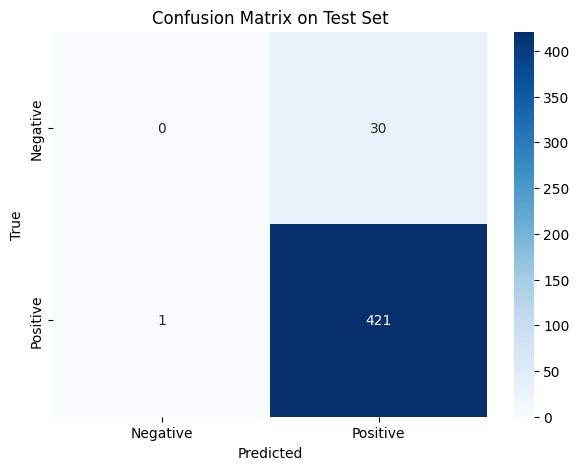


Overall Test Accuracy: 0.9314
Overall Test Loss: 1.1946


In [52]:
print("\n--- Evaluating on the Held-Out Test Set ---")

# 1. Get Predictions (probabilities)
test_pred_probs = model.predict(test_generator)

# 2. Get Predicted Classes (threshold at 0.5)
test_pred_classes = (test_pred_probs > 0.5).astype(int).flatten()

# 3. Get True Labels from the generator
test_true_labels = test_generator.classes 
class_labels = list(test_generator.class_indices.keys()) # ['Negative', 'Positive']

# 4. Calculate and Print Metrics
print("\n--- Classification Report ---")
print(classification_report(test_true_labels, test_pred_classes, target_names=class_labels))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(test_true_labels, test_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 5. Calculate overall test accuracy (optional, usually included in report)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nOverall Test Accuracy: {test_accuracy:.4f}")
print(f"Overall Test Loss: {test_loss:.4f}")